In [1]:
import gensim.downloader as api
import pandas as pd
import numpy as np
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.decomposition import PCA
# from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score, average_precision_score


2025-05-10 13:23:47.294179: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-10 13:23:47.298649: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-10 13:23:47.351562: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-10 13:23:47.352791: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-10 13:23:48.319359: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
csv = "../../data/contaminated/contaminated_data_irm.csv"
contaminated = pd.read_csv(csv).iloc[:, 0]
indices = np.load("../../data/contaminated/contaminated_data_irm.npy").flatten().tolist()

In [3]:
contaminated.size

3419

In [4]:
def vetorisation_sbert(data, indice_anomalie=None):
    model = SentenceTransformer('sentence-transformers/all-distilroberta-v1')
    vecteurs = model.encode(data)
    vecteurs = np.array(vecteurs)

    tsne = TSNE(n_components=2, random_state=42)  
    vecteurs_2d = tsne.fit_transform(vecteurs)  
    
    # couleurs des points ( rouge : anomalie, bleu : noraml)
    couleurs = ['b'] * len(data)
    if indice_anomalie:
        for i in indice_anomalie:
            if 0 <= i < len(data): 
                couleurs[i] = 'r'

    plt.figure(figsize=(60, 30)) 
    plt.scatter(vecteurs_2d[:, 0], vecteurs_2d[:, 1], c=couleurs, marker='o') 

    plt.title("Représentation graphique des documents vectorisés")
    plt.grid(True)
    #plt.savefig("output.jpg")
    plt.show()
    return vecteurs

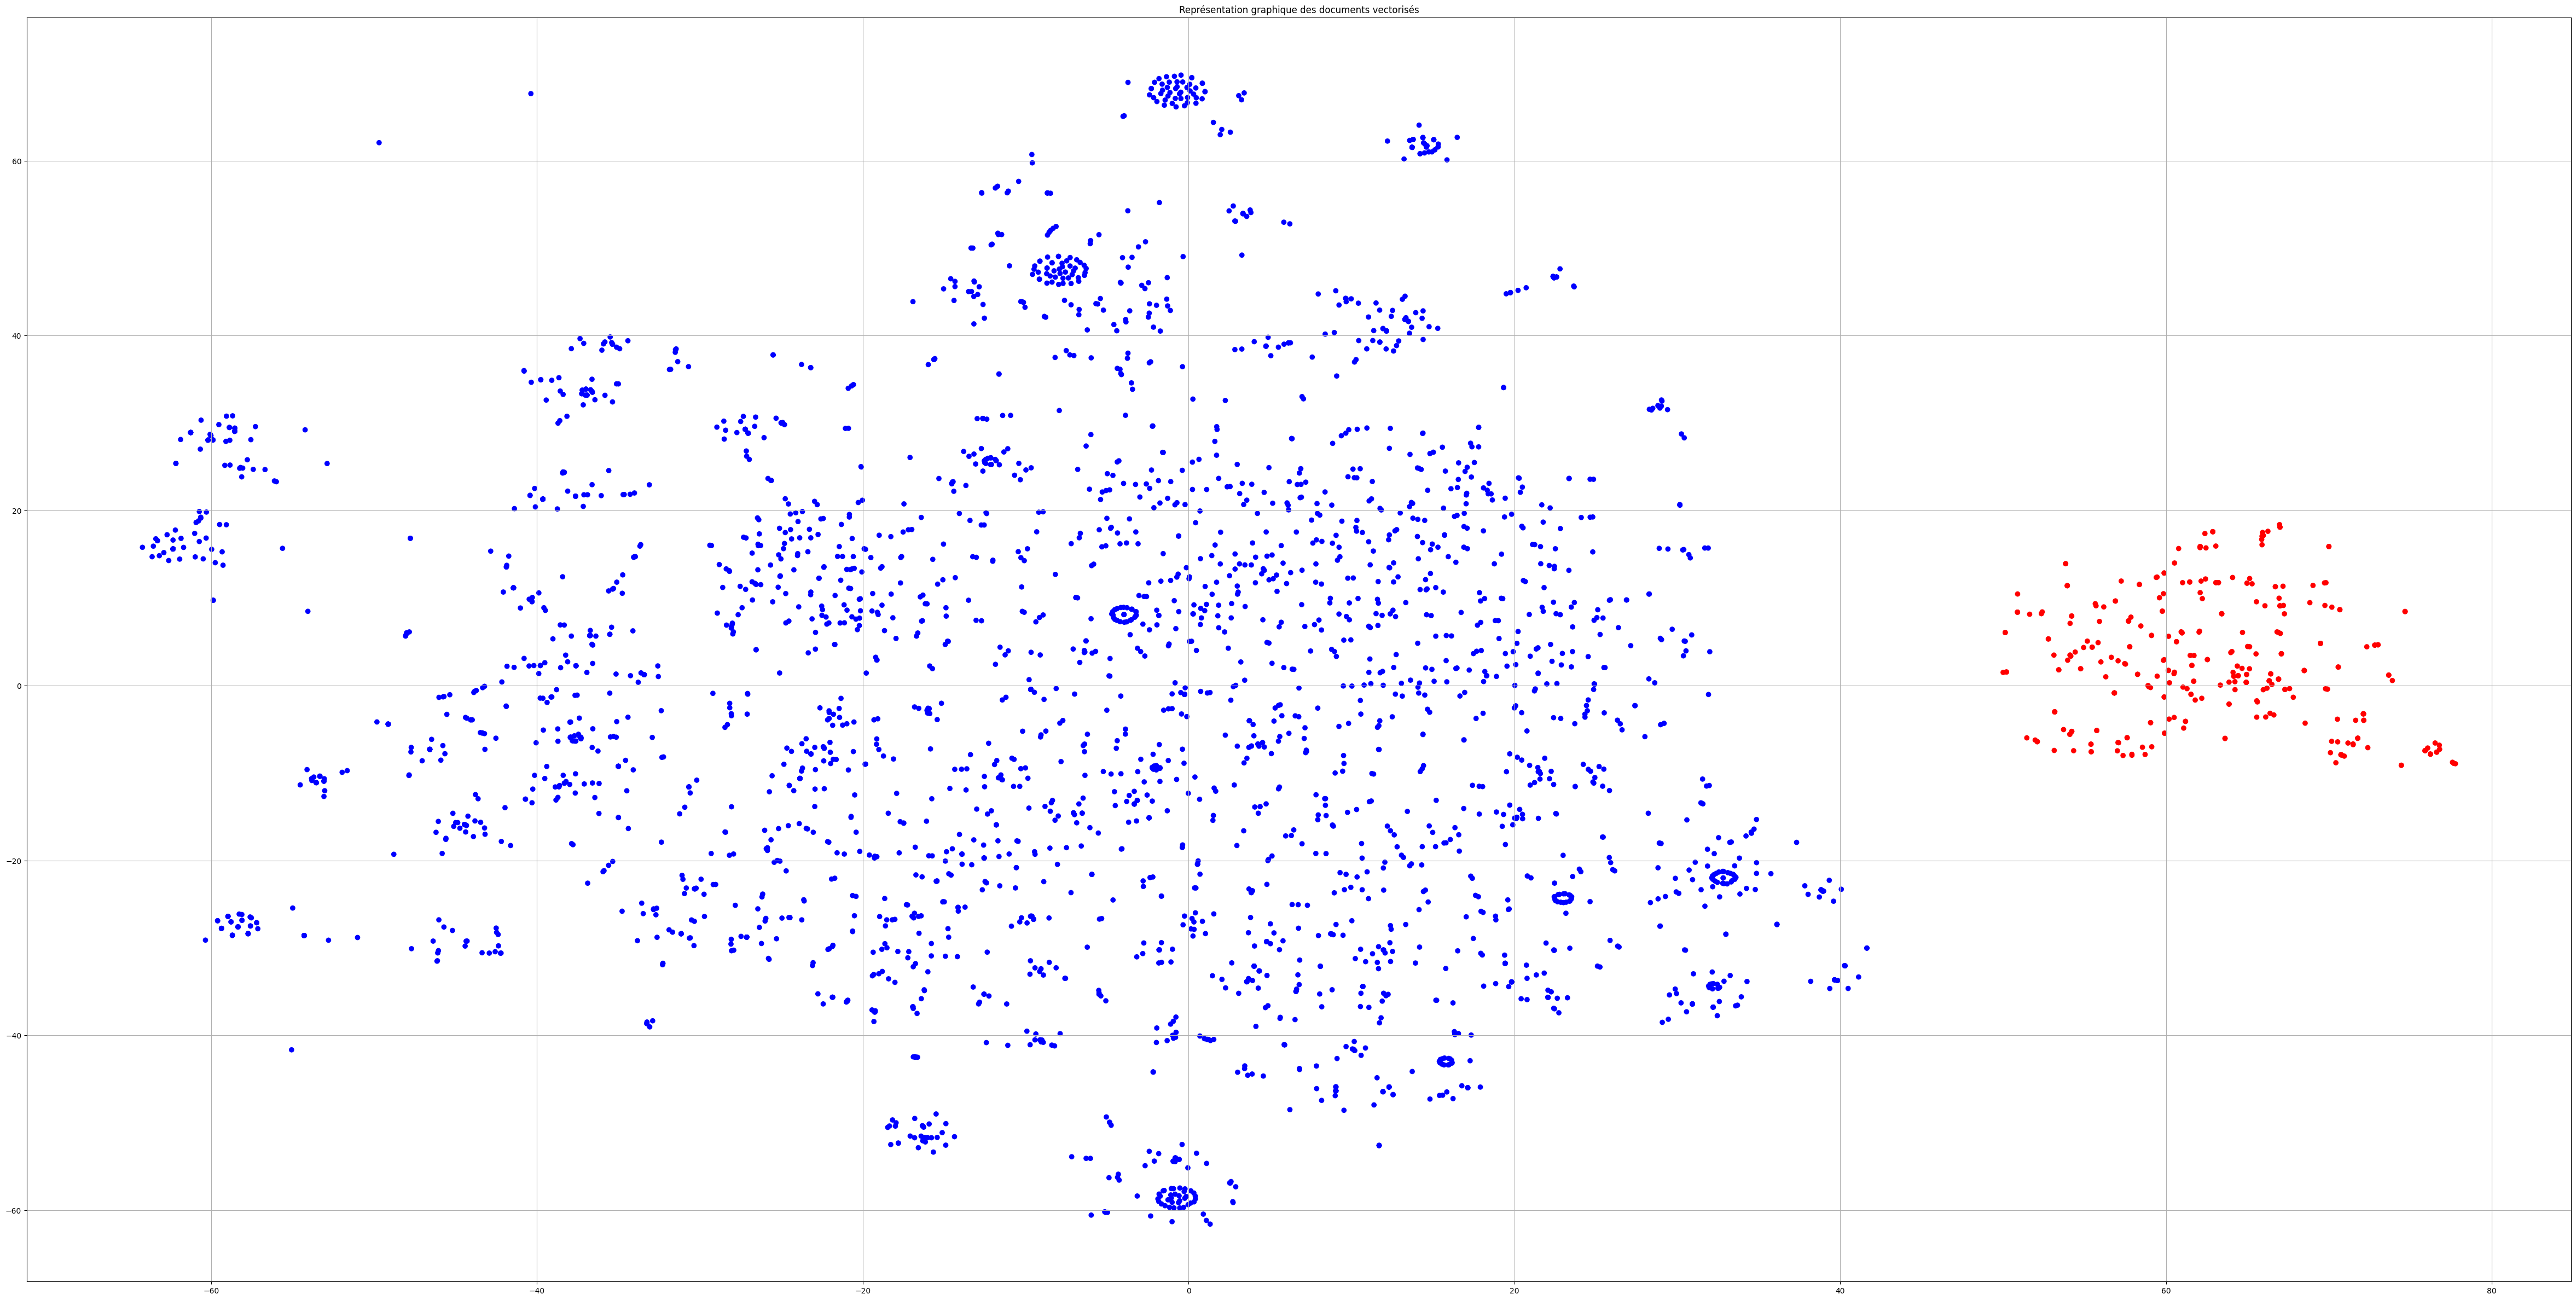

In [5]:
anomalie_sb = vetorisation_sbert(contaminated, indices)

In [6]:
# tsne = TSNE(n_components=2, random_state=42)  
# anomalie_sb = tsne.fit_transform(anomalie_sb)

anomaly_indices = indices  
normal_indices = list(set(contaminated.index) - set(anomaly_indices))

# Anomalies
anomaly_trainval_idx, anomaly_test_idx = train_test_split(anomaly_indices, test_size=0.2, random_state=42)
anomaly_train_idx, anomaly_val_idx = train_test_split(anomaly_trainval_idx, test_size=0.25, random_state=42)

# Normaux
normal_trainval_idx, normal_test_idx = train_test_split(normal_indices, test_size=0.2, random_state=42)
normal_train_idx, normal_val_idx = train_test_split(normal_trainval_idx, test_size=0.25, random_state=42)

# Index globaux
train_indices = anomaly_train_idx + normal_train_idx
val_indices = anomaly_val_idx + normal_val_idx
test_indices = anomaly_test_idx + normal_test_idx

# Données finales
df_train = anomalie_sb[train_indices]
df_val = anomalie_sb[val_indices]
df_test = anomalie_sb[test_indices]

# Labels pour val et test
val_labels = np.isin(val_indices, anomaly_val_idx).astype(int)
test_labels = np.isin(test_indices, anomaly_test_idx).astype(int)

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),    
            nn.ReLU(),
            nn.Linear(256, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

In [8]:
anomalie_tensor = torch.tensor(df_train, dtype=torch.float32)
dataset = TensorDataset(anomalie_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

model = Autoencoder(input_dim=df_train.shape[1], latent_dim=64)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

val_tensor = torch.tensor(df_val, dtype=torch.float32)

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in dataloader:
        inputs = batch[0]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # 🔍 Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_tensor)
        val_mse = torch.mean((val_tensor - val_outputs) ** 2, dim=1).numpy()

        threshold_tmp = np.percentile(val_mse, 95)  # seuil temporaire : top 5%
        val_preds = (val_mse > threshold_tmp).astype(int)
        val_f1 = f1_score(val_labels, val_preds)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {total_loss/len(dataloader):.4f}, Val F1: {val_f1:.4f}")


Epoch 1/50, Train Loss: 0.0218, Val F1: 0.5631
Epoch 2/50, Train Loss: 0.0014, Val F1: 0.6796
Epoch 3/50, Train Loss: 0.0011, Val F1: 0.6796
Epoch 4/50, Train Loss: 0.0011, Val F1: 0.6796
Epoch 5/50, Train Loss: 0.0008, Val F1: 0.6796
Epoch 6/50, Train Loss: 0.0008, Val F1: 0.6796
Epoch 7/50, Train Loss: 0.0008, Val F1: 0.6796
Epoch 8/50, Train Loss: 0.0010, Val F1: 0.6796
Epoch 9/50, Train Loss: 0.0011, Val F1: 0.6796
Epoch 10/50, Train Loss: 0.0008, Val F1: 0.6796
Epoch 11/50, Train Loss: 0.0008, Val F1: 0.6796
Epoch 12/50, Train Loss: 0.0011, Val F1: 0.6796
Epoch 13/50, Train Loss: 0.0006, Val F1: 0.6796
Epoch 14/50, Train Loss: 0.0005, Val F1: 0.6796
Epoch 15/50, Train Loss: 0.0006, Val F1: 0.6796
Epoch 16/50, Train Loss: 0.0006, Val F1: 0.6796
Epoch 17/50, Train Loss: 0.0006, Val F1: 0.6796
Epoch 18/50, Train Loss: 0.0008, Val F1: 0.6796
Epoch 19/50, Train Loss: 0.0005, Val F1: 0.6796
Epoch 20/50, Train Loss: 0.0005, Val F1: 0.6796
Epoch 21/50, Train Loss: 0.0005, Val F1: 0.6796
E


🔥 Meilleur seuil trouvé : 0.001229
📈 F1-score optimal : 0.9403

📊 Rapport de classification :

              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99       616
    Anomalie       0.97      0.91      0.94        69

    accuracy                           0.99       685
   macro avg       0.98      0.95      0.97       685
weighted avg       0.99      0.99      0.99       685

AUC ROC : 0.9549
Average precision : 0.8937


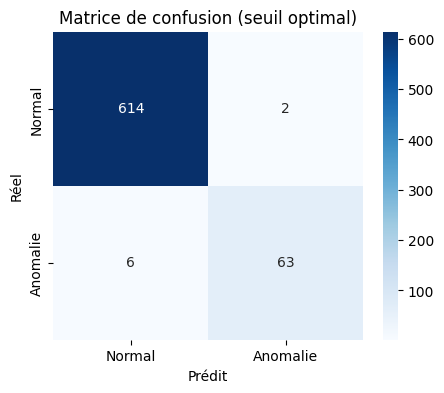

In [9]:
model.eval()
with torch.no_grad():
    inputs = torch.tensor(df_test, dtype=torch.float32)
    reconstructions = model(inputs)
    mse = torch.mean((inputs - reconstructions) ** 2, dim=1)

mse = mse.numpy()  # Convertir en numpy pour sklearn


# labels = [indices des anomalies connues]
labels = test_labels

# le meilleur seuil basé sur le F1-score 

thresholds = np.linspace(mse.min(), mse.max(), 200)
best_f1 = 0
best_threshold = 0

f1_scores = []

for t in thresholds:
    preds = (mse > t).astype(int)
    f1 = f1_score(labels, preds)
    f1_scores.append(f1)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"\n🔥 Meilleur seuil trouvé : {best_threshold:.6f}")
print(f"📈 F1-score optimal : {best_f1:.4f}")

# evaluer avec le meilleur seuil

y_pred = (mse > best_threshold).astype(int)
y_true = labels

print("\n📊 Rapport de classification :\n")
print(classification_report(y_true, y_pred, target_names=["Normal", "Anomalie"]))

y_score = mse 
roc_auc_ae = roc_auc_score(y_true, y_pred)
avg_precision_ae = average_precision_score(y_true, y_pred)

print(f"AUC ROC : {roc_auc_ae:.4f}")
print(f"Average precision : {avg_precision_ae:.4f}")

# matrice de confusion 

cm_ae = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_ae, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Anomalie"],
            yticklabels=["Normal", "Anomalie"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion (seuil optimal)")
plt.show()


In [10]:
isolation_forest = IsolationForest()
isolation_forest.fit(df_train)

IsolationForest()

In [11]:
val_scores = -isolation_forest.decision_function(df_val)
val_thresholds = np.linspace(min(val_scores), max(val_scores), 200)

best_f1 = 0
best_threshold = 0

for t in val_thresholds:
    preds = (val_scores >= t).astype(int)
    f1 = f1_score(val_labels, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t


📊 Rapport de classification :
              precision    recall  f1-score   support

      Normal       0.98      0.90      0.94       616
    Anomalie       0.48      0.80      0.60        69

    accuracy                           0.89       685
   macro avg       0.73      0.85      0.77       685
weighted avg       0.93      0.89      0.90       685

🎯 AUC ROC : 0.9502
Average precision : 0.4017


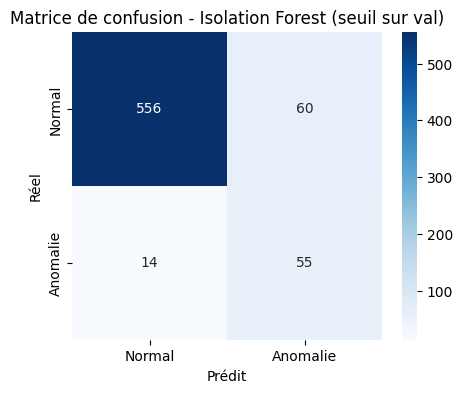

In [12]:
test_scores = -isolation_forest.decision_function(df_test)
y_pred = (test_scores >= best_threshold).astype(int)

print("\n📊 Rapport de classification :")
print(classification_report(test_labels, y_pred, target_names=["Normal", "Anomalie"]))

roc_auc_if = roc_auc_score(test_labels, test_scores)
avg_precision_if = average_precision_score(test_labels, y_pred)

print(f"🎯 AUC ROC : {roc_auc_if:.4f}")
print(f"Average precision : {avg_precision_if:.4f}")

cm_if = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_if, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Anomalie"],
            yticklabels=["Normal", "Anomalie"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion - Isolation Forest (seuil sur val)")
plt.show()


In [13]:
oc_svm = OneClassSVM(kernel='linear', gamma='scale') #poly 0.67 rbf 0.68
oc_svm.fit(df_train)

OneClassSVM(kernel='linear')

In [14]:
svm_pred_val = oc_svm.decision_function(df_val)
svm_scores_val = -svm_pred_val 

thresholds = np.linspace(min(svm_scores_val), max(svm_scores_val), 200)

best_f1 = 0
best_threshold = 0

for t in thresholds:
    preds_val = (svm_scores_val >= t).astype(int)
    f1_val = f1_score(val_labels, preds_val)
    if f1_val > best_f1:
        best_f1 = f1_val
        best_threshold = t


📊 Rapport de classification :
              precision    recall  f1-score   support

      Normal       0.99      0.98      0.99       616
    Anomalie       0.87      0.94      0.90        69

    accuracy                           0.98       685
   macro avg       0.93      0.96      0.95       685
weighted avg       0.98      0.98      0.98       685

🎯 AUC ROC : 0.9967
Average precision : 0.8223


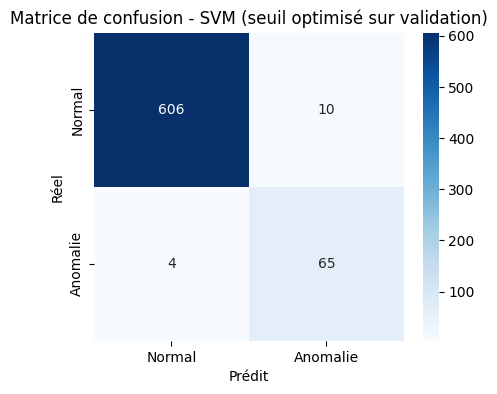

In [15]:
svm_pred_test = oc_svm.decision_function(df_test)
svm_scores_test = -svm_pred_test  
y_pred_test = (svm_scores_test >= best_threshold).astype(int)

print("\n📊 Rapport de classification :")
print(classification_report(test_labels, y_pred_test, target_names=["Normal", "Anomalie"]))

roc_auc_svm = roc_auc_score(test_labels, svm_scores_test)
avg_precision_svm = average_precision_score(test_labels, y_pred_test)

print(f"🎯 AUC ROC : {roc_auc_svm:.4f}")
print(f"Average precision : {avg_precision_svm:.4f}")

cm_svm = confusion_matrix(test_labels, y_pred_test)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Anomalie"],
            yticklabels=["Normal", "Anomalie"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion - SVM (seuil optimisé sur validation)")
plt.show()

In [19]:
results = {
    "Autoencoder": {
        "avg_prec": avg_precision_ae,
        "roc_auc": roc_auc_ae,
        "cm": cm_ae
    },
    "IsolationForest": {
        "avg_prec": avg_precision_if,
        "roc_auc": roc_auc_if,
        "cm": cm_if
    },
    "SVM": {
        "avg_prec": avg_precision_svm,
        "roc_auc": roc_auc_svm,
        "cm": cm_svm
    }
}

for method, metrics in results.items():
    cm = metrics["cm"]
    tn, fp, fn, tp = cm.ravel()
    total_pos = tp + fn
    total_neg = tn + fp

    results[method]["TPR %"] = round(tp / total_pos * 100, 2) if total_pos else 0  # Sensibilité (Recall)
    results[method]["FPR %"] = round(fp / total_neg * 100, 2) if total_neg else 0  # Faux positifs
    results[method]["TNR %"] = round(tn / total_neg * 100, 2) if total_neg else 0  # Spécificité
    results[method]["FNR %"] = round(fn / total_pos * 100, 2) if total_pos else 0  # Faux négatifs

In [20]:
benchmark_data = {
    method: {k: v for k, v in metrics.items() if k != "cm"}
    for method, metrics in results.items()
}

# Création du DataFrame
benchmark_df = pd.DataFrame(benchmark_data).T  # Méthodes en lignes
benchmark_df = benchmark_df.round(4)

# Affichage final
print("\n📊 Benchmark complet :\n")
print(benchmark_df)


📊 Benchmark complet :

                 avg_prec  roc_auc  TPR %  FPR %  TNR %  FNR %
Autoencoder        0.8937   0.9549  91.30   0.32  99.68   8.70
IsolationForest    0.4017   0.9502  79.71   9.74  90.26  20.29
SVM                0.8223   0.9967  94.20   1.62  98.38   5.80


In [21]:
benchmark_df.to_csv("../../benchmarks/benchmark_result_3.csv")